In [1]:
from huggingface_hub import hf_hub_download
from datasets import load_dataset
import datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from sklearn_extra.cluster import KMedoids
from nltk.tokenize import word_tokenize
from gensim.models import word2vec
import gensim
import pickle
import funcs
import seaborn as sns

In [4]:
df = pd.read_pickle('../data/tifu_cleaned.pkl')

## Clustering


In this section we will focus on utilizing different methods in order to clusterize the text from r/tifu subreddit.
Optimal cluster value will be selected utilizing silhouette value using MiniBatchKMeans in order to speed up the tuning process.


### Defining needed functions

In [ ]:
For further information on function definition, check out funcs.py file where they are located.

In [ ]:
We are using stardard Term frequency – inverse document frequency Vectorizer in order to represent subreddit posts as vectors. 

In [7]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.95,
    max_features=4353,
    stop_words='english'
)

text_tfidf = tfidf.fit_transform(df['documents_lem'])

#### Finding optimal clusters 

Fit 2 clusters - Silhouette Score: 0.0029466455494314924


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 4 clusters - Silhouette Score: 0.0020058700448387606


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 6 clusters - Silhouette Score: 0.0024681888729672628


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 8 clusters - Silhouette Score: -9.629962285889297e-06


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 10 clusters - Silhouette Score: 0.0021565730785297562


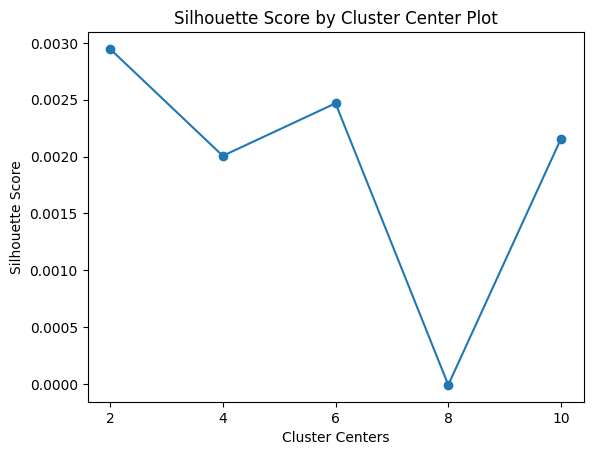

In [57]:
# Find optimal clusters
find_optimal_clusters(text_tfidf, 10)

In [ ]:
# Clustering using MiniBatchKMeans
optimal_clusters = 6  # Adjust based on your findings
clusters_tfidf = MiniBatchKMeans(n_clusters=optimal_clusters, init_size=1024, batch_size=2048, random_state=20).fit_predict(text_tfidf)
clusters_kmedoids = KMedoids(n_clusters=optimal_clusters, metric='cosine', random_state=20).fit_predict(text_tfidf)

As we can see from the chart above, a silhouette value indicates a decidedly weak/neutral assignment of values to clusters, a score close to 0 indicates observations that are on the borderline of several clusters. However we have decided to move on with analysis and see whether in fact there is no potential clustering method applicable that could categorize the text data in some way. As the optimal choice we have decided to go with 6 clusters, because of the seemingly still low amount of clusters and relatively high silhouette score.



#### KMeedoids Clustering

Below can be seen 2D PCA and t-SNE representation of 6 clusters based on K-Medoids algorithm. The charts tentatively confirm our assumptions about low clusterization potential, especially in 2-dimensional space.

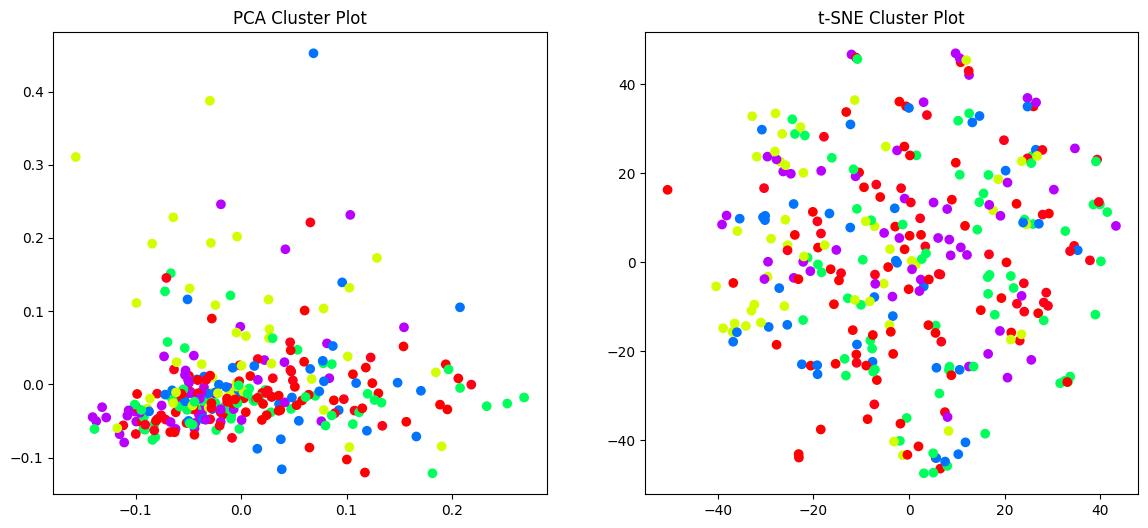

In [103]:
# Plotting PCA and t-SNE
plot_tsne_pca(text_tfidf, clusters_kmedoids)
plt.show()

#### KMeans Clustering

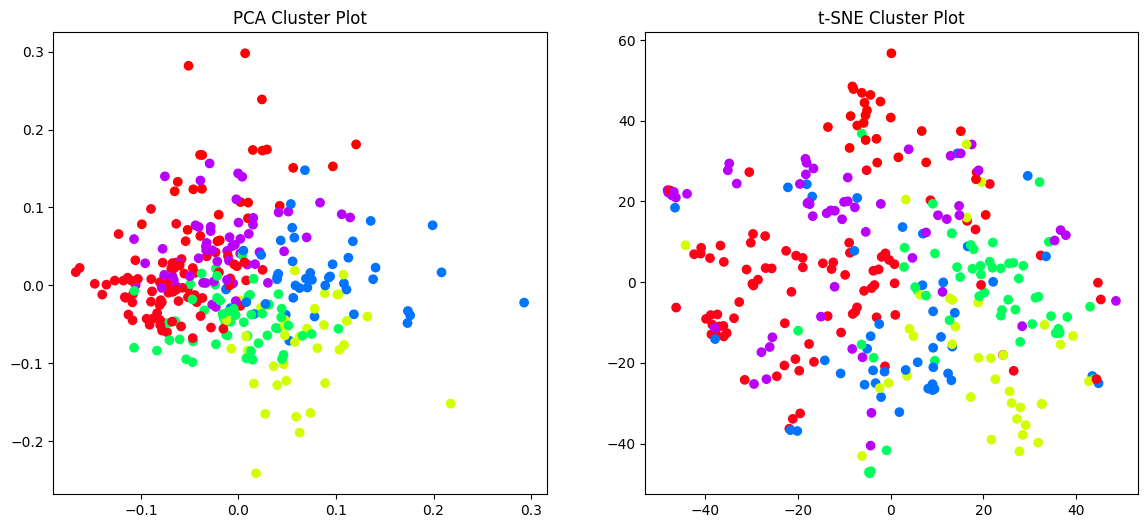

In [50]:
# Plotting PCA and t-SNE
plot_tsne_pca(text_tfidf, clusters_tfidf)
plt.show()

In [100]:
get_top_keywords(text_tfidf, clusters_tfidf, tfidf.get_feature_names_out(), 5)


Cluster 0
dried,resulted,jewish,dreaming,careful

Cluster 1
free,freak,team,chunks,sale

Cluster 2
toe,golfing,jewish,woke,partner

Cluster 3
times,question,gf,lending,jewish

Cluster 4
benefits,jewish,hottest,review,dmv

Cluster 5
golfing,omegle,war,jewish,lending


In [101]:
get_top_keywords(text_tfidf, clusters_kmedoids, tfidf.get_feature_names_out(), 5)


Cluster 0
lending,jewish,question,golfing,sale

Cluster 1
friendship,fridge,lending,jewish,partner

Cluster 2
golfing,desktop,roommate,lending,jewish

Cluster 3
times,careful,lending,jewish,freak

Cluster 4
times,vacuum,careful,jewish,woke

Cluster 5
hottest,bragging,freak,bee,jewish


#### Assign clusters

In [51]:
df['cluster'] = clusters_tfidf

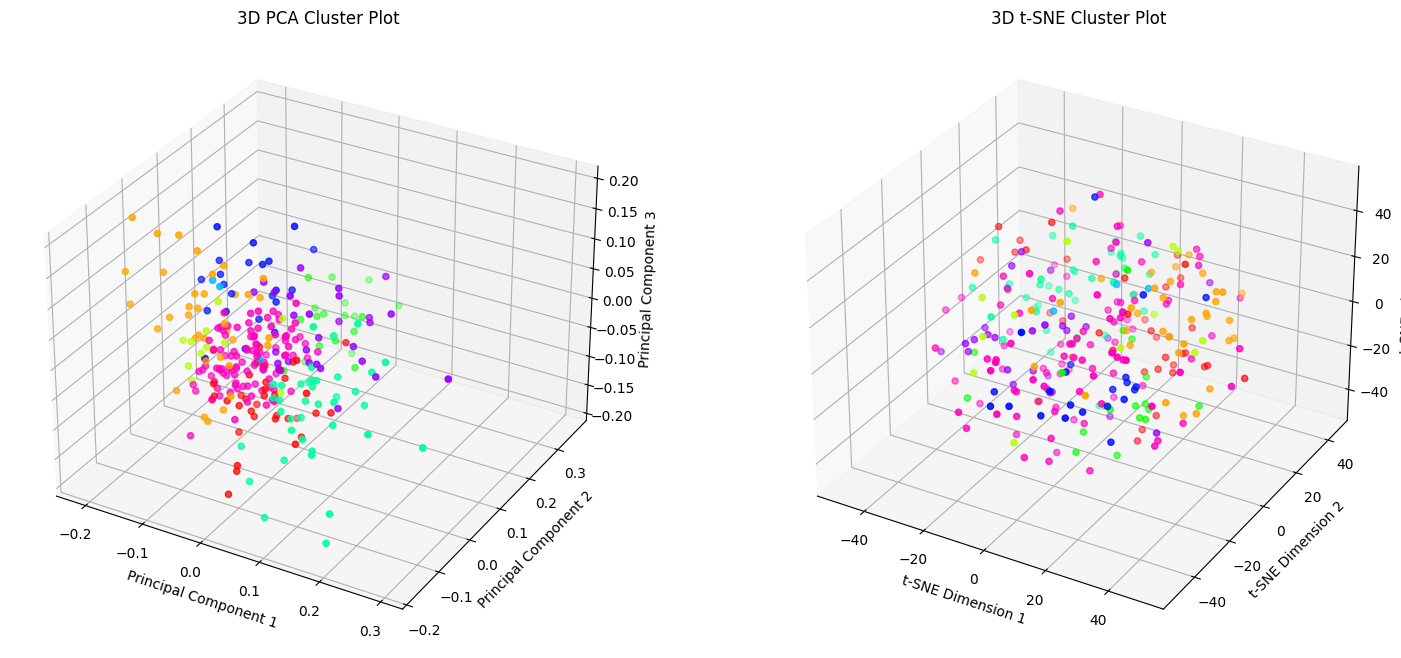

In [39]:
# Call the 3D PCA plot function
plot_3d_pca_tsna(text_tfidf, clusters_tfidf)
#plot_3d_pca_tsna(text_tfidf, clusters_tfidf)

## Word Embedding

In [32]:
df[df['documents_lem'].apply(lambda x: not x)]


,ups,num_comments,upvote_ratio,score,documents_lem,tldr_lem,title_lem
24268,506.0,256.0,0.81,506.0,,stori old time least airplan guy sit next cute...,ask want continu convers
30234,70.0,44.0,0.87,70.0,,old friend live storag unit husband call infor...,let friend move walkin closet


In [20]:
tokenized_sentences = [sentence.split() for sentence in df['documents_lem']]
model = word2vec.Word2Vec(tokenized_sentences,  vector_size=50, window=5, min_count=1, workers=10)

non_empty_tokenized_sentences = [doc for doc in tokenized_sentences if doc]

embeddings = [np.mean([model.wv[word] for word in doc], axis=0) for doc in tokenized_sentences]
embeddings_np = np.array(embeddings)
data_standardized = StandardScaler().fit_transform(embeddings)

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Assuming 'tokenized_text' is a list of tokenized sentences
find_optimal_clusters_with_embeddings(tokenized_sentences, max_k=10)

In [104]:
clusters_kmeans = MiniBatchKMeans(n_clusters=4, init_size=1024, batch_size=2048, random_state=20).fit_predict(data_standardized)


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [111]:
np.random.choice(range(pca.shape[0]), size=300, replace=False)

NameError: name 'pca' is not defined

In [126]:
label_subset.max()

3

In [ ]:
max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=42137, replace=False)

    data_subset = np.asarray(data[max_items, :])

    n_components_pca = min(data_subset.shape[0], data_subset.shape[1])
    pca = PCA(n_components=n_components_pca).fit_transform(data_subset)

    tsne = TSNE().fit_transform(pca)

    idx = np.random.choice(range(pca.shape[0]), size=1500, replace=False)
    label_subset = labels[max_items]
    unique_labels = np.unique(label_subset)

    colors = [plt.cm.hsv(i / max_label + 1) for i in unique_labels]

    label_colors = [colors[label - 1] for label in label_subset[idx]]

    f, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_colors)
    ax[0].set_title('PCA Cluster Plot')

    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_colors)
    ax[1].set_title('t-SNE Cluster Plot')

In [191]:
max_label = max(clusters_kmeans)
max_items = np.random.choice(range(embeddings_np.shape[0]), size=42137, replace=False)


In [195]:
n_components_pca = min(data_subset.shape[0], data_subset.shape[1])
pca = PCA(n_components=n_components_pca).fit_transform(data_subset)

In [196]:
idx = np.random.choice(range(pca.shape[0]), size=1500, replace=False)
label_subset = clusters_kmeans[max_items]

In [197]:
distinct_colors = ['red', 'green', 'blue', 'purple']  # Add more colors if needed


In [199]:
label_color = [distinct_colors[label - 1] for label in label_subset[idx]]

In [204]:
label_subset = clusters_kmeans[max_items]
unique_labels = np.unique(label_subset)

palette = sns.color_palette("husl", n_colors=len(unique_labels))
label_colors = [palette[label - 1] for label in label_subset[idx]]

In [205]:
label_colors

[(0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9677975592919913, 0.44127456009157356, 0.535810

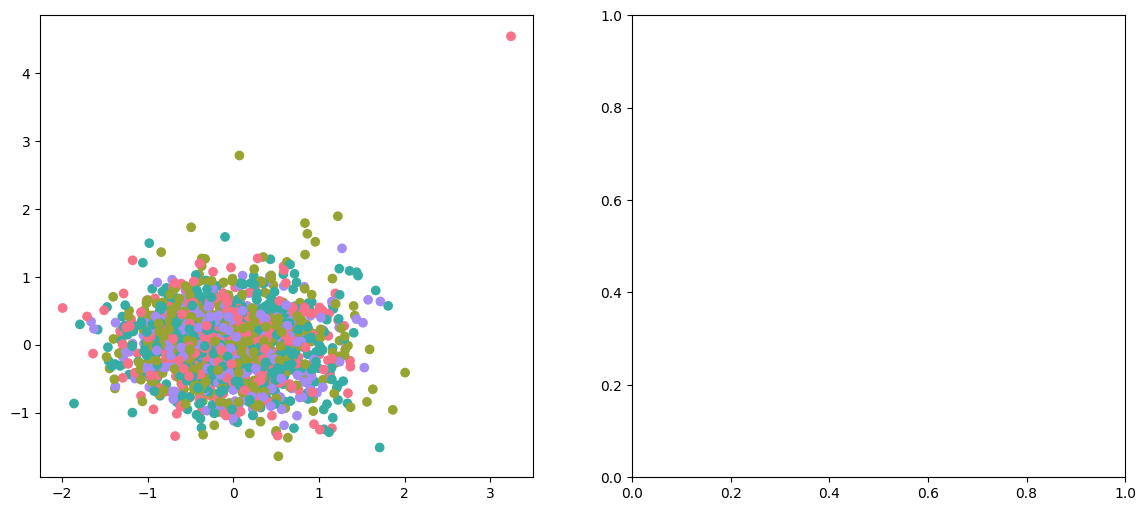

In [206]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_colors)

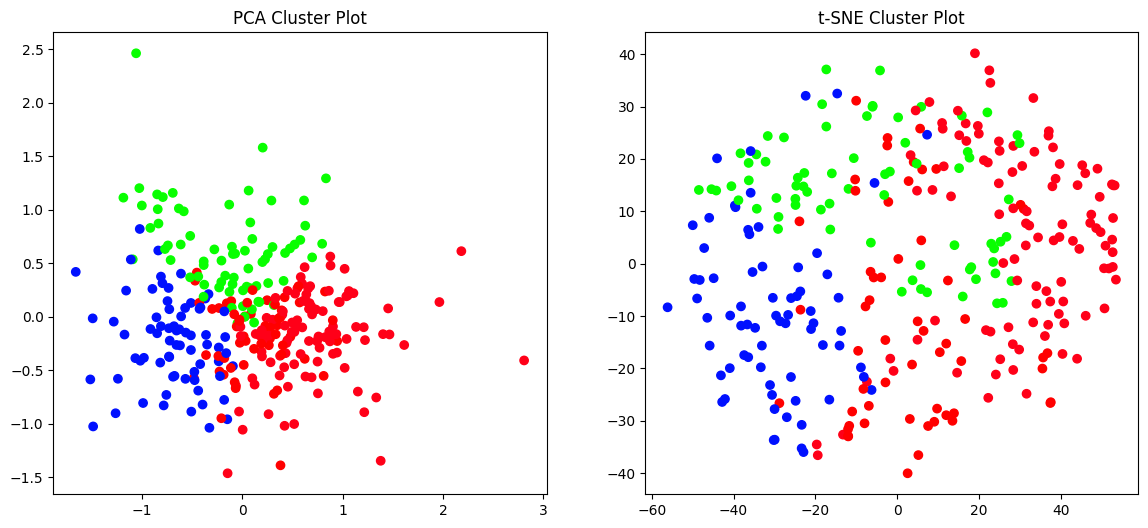

In [208]:
# Plotting PCA and t-SNE
plot_tsne_pca_emb(embeddings_np, clusters_kmeans)


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 2 clusters - Silhouette Score: 0.09977070838065276


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 4 clusters - Silhouette Score: 0.06385353507565042


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 6 clusters - Silhouette Score: 0.052652167804593836


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 8 clusters - Silhouette Score: 0.04830299888699646


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 10 clusters - Silhouette Score: 0.04647113902834606


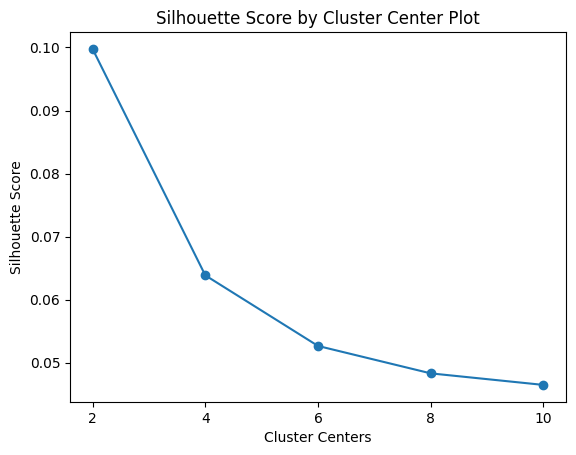

In [78]:
find_optimal_clusters_with_embeddings(tokenized_sentences, max_k=10)

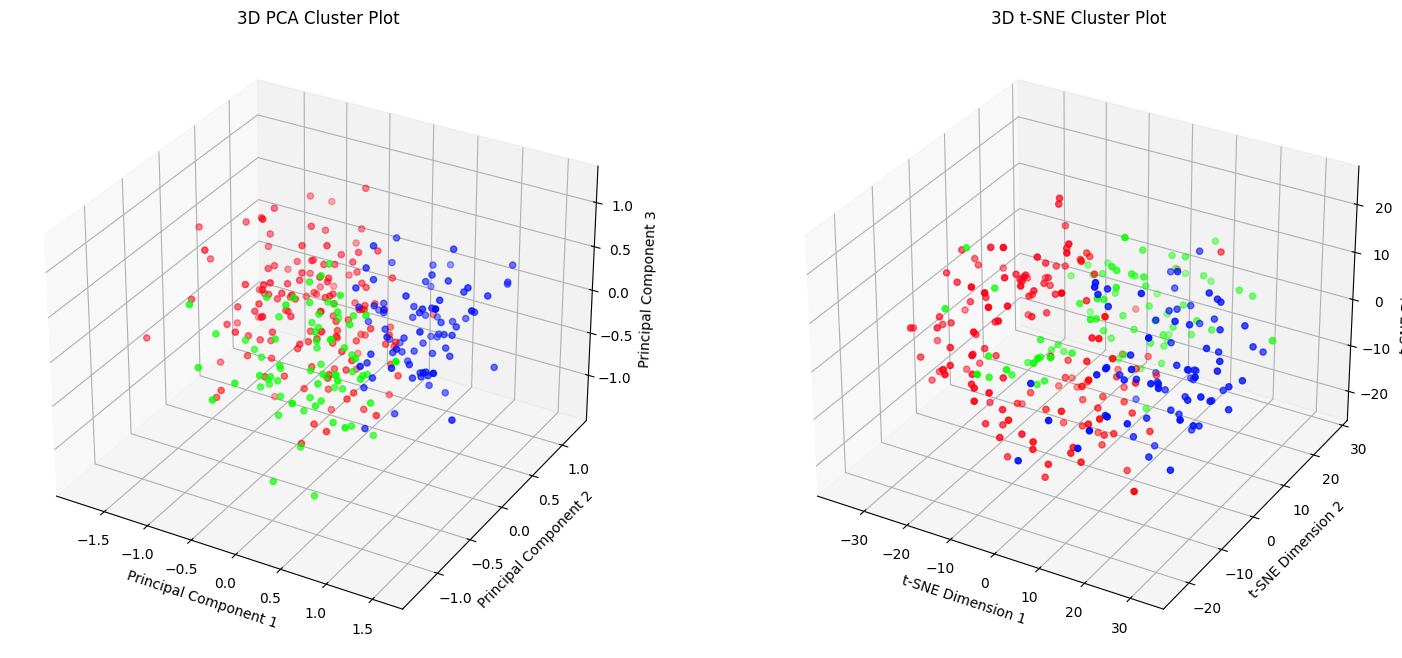

In [152]:
plot_3d_pca_tsna_emb(embeddings_np, clusters_kmeans)